# Lectura de datos

Es necesario leer los datos en un DF (DataFrame) vamos a crear la siguiente función


In [21]:
from glob import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import timedelta

def read_streaming_history():
    history = []
    for file in sorted(glob("StreamingHistory0.json")):
        with open(file, encoding='utf-8') as readable:
            history.extend(json.load(readable))
    history = pd.DataFrame(history)
    history["endTime"] = pd.to_datetime(history["endTime"])
    return history

streaming_history = read_streaming_history()
streaming_history.head(5)


,endTime,artistName,trackName,msPlayed
0,2021-08-22 22:38:00,Kendrick Lamar,Money Trees,20837
1,2021-08-22 22:40:00,Kanye West,Father Stretch My Hands Pt. 1,91736
2,2021-08-22 22:42:00,Offset,Legacy (feat. Travis Scott & 21 Savage),170796
3,2021-08-22 22:43:00,Kanye West,Selah,20861
4,2021-08-22 22:44:00,Kendrick Lamar,HUMBLE.,99050


In [22]:
streaming_history["date"] = streaming_history["endTime"].dt.floor('d')
by_date = streaming_history.groupby("date")[["trackName"]].count()
by_date = by_date.sort_index()
by_date["weekday"] = by_date.index.weekday
by_date["week"] = by_date.index.week
by_date.head()

<ipython-input-22-bbf121c5bd20>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  by_date["week"] = by_date.index.week


,trackName,weekday,week
date,,,
2021-08-22,70,6,33
2021-08-23,10,0,34
2021-08-24,45,1,34
2021-08-25,1,2,34
2021-08-27,355,4,34


In [23]:
week = 0
prev_week = by_date.iloc[0]["week"]
continuous_week = np.zeros(len(by_date)).astype(int)
sunday_dates = []
for i, (_, row) in enumerate(by_date.iterrows()):
    if row["week"] != prev_week:
        week += 1
        prev_week = row["week"]
    continuous_week[i] = week
by_date["continuous_week"] = continuous_week 
by_date.head()

,trackName,weekday,week,continuous_week
date,,,,
2021-08-22,70,6,33,0
2021-08-23,10,0,34,1
2021-08-24,45,1,34,1
2021-08-25,1,2,34,1
2021-08-27,355,4,34,1


<AxesSubplot:>

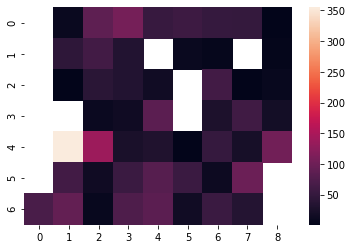

In [24]:
songs = np.full((7, continuous_week.max()+1), np.nan)

for index, row in by_date.iterrows():
    songs[row["weekday"]][row["continuous_week"]] = row["trackName"]

sns.heatmap(songs)

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of ticklabels (8).

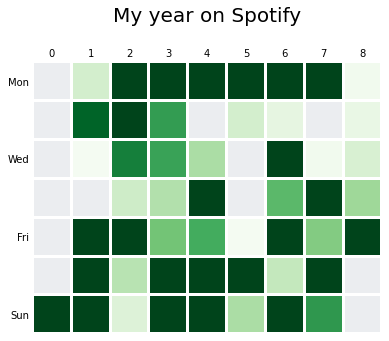

In [26]:
min_date = streaming_history["endTime"].min()
first_monday = min_date - timedelta(min_date.weekday())
mons = [first_monday + timedelta(weeks=wk) for wk in range(continuous_week.max())]
x_labels = [calendar.month_abbr[mons[0].month]]
x_labels.extend([
    calendar.month_abbr[mons[i].month] if mons[i-1].month != mons[i].month else "" 
    for i in range(1, len(mons))])

y_labels = ["Mon", "", "Wed", "", "Fri", "", "Sun"]

fig = plt.figure(figsize=(20,5))
ax = plt.subplot()

ax.set_title("My year on Spotify", fontsize=20,pad=40)
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='both',length=0)
ax.set_facecolor("#ebedf0") 
fig.patch.set_facecolor('white')

sns.heatmap(songs, linewidths=2, linecolor='white', square=True,
            mask=np.isnan(songs), cmap="Greens",
            vmin=0, vmax=50, cbar=False, ax=ax)

ax.set_yticklabels(y_labels, rotation=0)
ax.set_xticklabels(x_labels, ha="left")
pass